In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
df = pd.read_excel('/kaggle/input/planet-hunt-dataset/Study_of_exoplanets.xlsx')

In [3]:
# 1. Inspect the data type and Extract basic statistics: [15] 1.1 Print Range, Mean, Median, and Standard Deviation of any 3 features of the dataset. [5]

selected_features = ['P_ECCENTRICITY', 'P_RADIUS', 'P_SEMI_MAJOR_AXIS']
for feature in selected_features:
    print(f"Feature: {feature}")
    print(f"Range: {df[feature].min()} - {df[feature].max()}")
    print(f"Mean: {df[feature].mean()}")
    print(f"Median: {df[feature].median()}")
    print(f"Standard Deviation: {df[feature].std()}")
    print("\n")


Feature: P_ECCENTRICITY
Range: 0.0 - 0.95
Mean: 0.16155059420072465
Median: 0.1
Standard Deviation: 0.18794823274468214


Feature: P_RADIUS
Range: 0.3363 - 77.349
Mean: 4.191425871296591
Median: 2.33168
Standard Deviation: 4.776829779149984


Feature: P_SEMI_MAJOR_AXIS
Range: 0.0044 - 2500.0
Mean: 6.626030346008027
Median: 0.118
Standard Deviation: 80.78324047273993




In [4]:
# 1.2 Does the Dataset require Normalisation? [5]

from sklearn.preprocessing import MinMaxScaler # type: ignore

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Select only numeric columns for normalization
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Apply Min-Max scaling to all numeric columns
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

df_normalized = df.copy()

# Print the normalized DataFrame
print(df_normalized)

          P_NAME  P_STATUS    P_MASS  P_MASS_ERROR_MIN  P_MASS_ERROR_MAX  \
0       11 Com b       0.0  0.348983          0.980893          0.017902   
1       11 UMi b       0.0  0.265155          0.968163          0.029836   
2       14 And b       0.0  0.086345               NaN               NaN   
3       14 Her b       0.0  0.083827          0.998080          0.001790   
4     16 Cyg B b       0.0  0.032019          0.998971          0.000955   
...          ...       ...       ...               ...               ...   
4043    K2-296 b       0.0       NaN               NaN               NaN   
4044    K2-296 c       0.0       NaN               NaN               NaN   
4045   GJ 1061 b       0.0  0.000077          0.999995          0.000006   
4046   GJ 1061 c       0.0  0.000098          0.999998          0.000009   
4047   GJ 1061 d       0.0  0.000094          0.999999          0.000009   

      P_RADIUS  P_RADIUS_ERROR_MIN  P_RADIUS_ERROR_MAX    P_YEAR  \
0          NaN     

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [5]:
'''
1.3 What are your inferences based on the above results? [5]
P_ECCENTRICITY:
With a mean of 0.1616 and a median of 0.1, the data exhibits a broad range from 0.0 to 0.95.
The comparatively high standard deviation (0.1879) suggests that eccentricity values vary significantly.

P_RADIUS:
The planet radius ranges from 0.3363 to 77.349 Earth radii, which is a quite wide range.
The comparatively high standard deviation (4.7768) and the fact that the mean (4.1914) is greater than the median (2.33168) both point to right skewness.

P_SEMI_MAJOR_AXIS:
With a range of 0.0044 to 2500.0 astronomical units (AU), the semi-major axis has an incredibly broad range.
There is a strong right skewness as the mean (6.626) is significantly higher than the median (0.118). Additionally quite high is the standard deviation (80.7832).

All things considered, it is clear that the features show considerable variability over vast ranges, particularly for P_SEMI_MAJOR_AXIS. The wide ranges and variations between means and medians in all three features demonstrate the existence of outliers. This implies that in order to guarantee that each of these features contributes equally to the process of analysis and modeling, normalization could be required. Nonetheless, given the existence of outliers, particularly in P_SEMI_MAJOR_AXIS, care should be taken because normalization methods can be sensitive to extremely high or low values.
2. Using the Seaborn module, plot a heatmap to explore the various planetary detection methods used over the years, What do you infer from the above heatmap? [10]
'''

'\n1.3 What are your inferences based on the above results? [5]\nP_ECCENTRICITY:\nWith a mean of 0.1616 and a median of 0.1, the data exhibits a broad range from 0.0 to 0.95.\nThe comparatively high standard deviation (0.1879) suggests that eccentricity values vary significantly.\n\nP_RADIUS:\nThe planet radius ranges from 0.3363 to 77.349 Earth radii, which is a quite wide range.\nThe comparatively high standard deviation (4.7768) and the fact that the mean (4.1914) is greater than the median (2.33168) both point to right skewness.\n\nP_SEMI_MAJOR_AXIS:\nWith a range of 0.0044 to 2500.0 astronomical units (AU), the semi-major axis has an incredibly broad range.\nThere is a strong right skewness as the mean (6.626) is significantly higher than the median (0.118). Additionally quite high is the standard deviation (80.7832).\n\nAll things considered, it is clear that the features show considerable variability over vast ranges, particularly for P_SEMI_MAJOR_AXIS. The wide ranges and varia

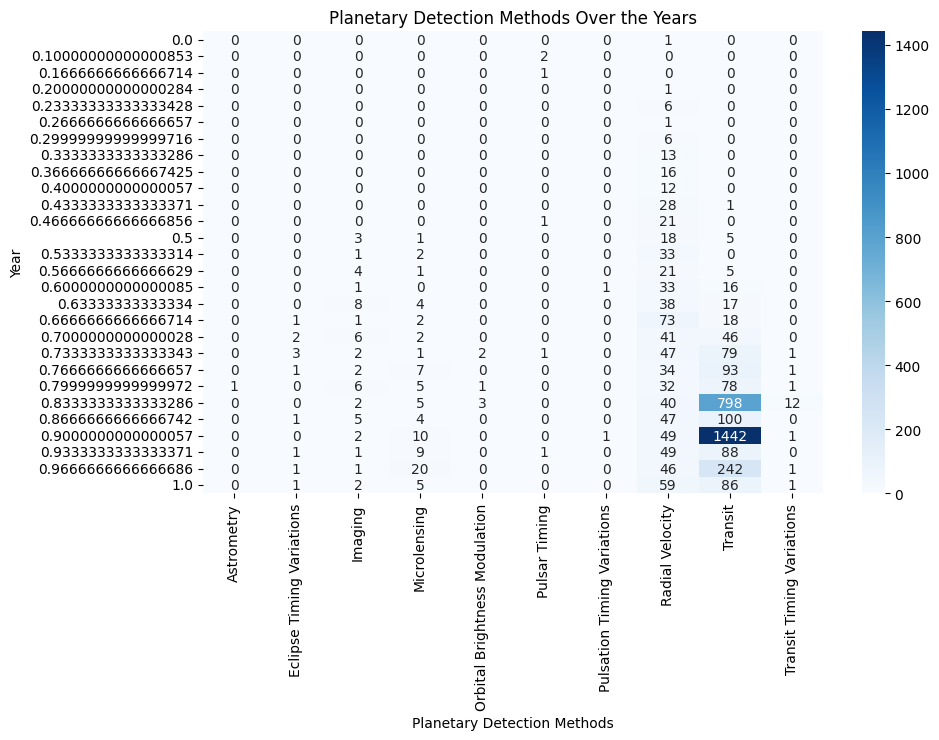

In [6]:
# We'll create a heatmap to visualize the count of planetary detection methods over the years.

# Prepare data for heatmap
heatmap_data = df.groupby(['P_YEAR', 'P_DETECTION']).size().unstack(fill_value=0)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='d', cbar=True)
plt.title('Planetary Detection Methods Over the Years')
plt.xlabel('Planetary Detection Methods')
plt.ylabel('Year')
plt.show()

In [7]:
'''3. Identify the planetary detection methods that have identified the most: [15]
i) Uninhabitable planets (0)
ii) Conservatively habitable planets (1)
iii) Optimistically habitable planets (2)'''

# We'll filter the dataset based on habitability classes and count the occurrences for each detection method.

# Step 1: Filter the dataset based on habitability classes
uninhabitable = df[df['P_HABITABLE'] == 0]
conservatively_habitable = df[df['P_HABITABLE'] == 1]
optimistically_habitable = df[df['P_HABITABLE'] == 2]

# Step 2: Group data by planetary detection methods and count occurrences
uninhabitable_counts = uninhabitable['P_DETECTION'].value_counts()
conservatively_habitable_counts = conservatively_habitable['P_DETECTION'].value_counts()
optimistically_habitable_counts = optimistically_habitable['P_DETECTION'].value_counts()

# Step 3: Identify the detection methods with the highest count
most_common_uninhabitable_detection = uninhabitable_counts.idxmax() if not uninhabitable_counts.empty else None
most_common_conservatively_habitable_detection = conservatively_habitable_counts.idxmax() if not conservatively_habitable_counts.empty else None
most_common_optimistically_habitable_detection = optimistically_habitable_counts.idxmax() if not optimistically_habitable_counts.empty else None

print("Planetary detection methods that have identified the most habitable planets:")
print("Uninhabitable:", most_common_uninhabitable_detection)
print("Conservatively habitable:", most_common_conservatively_habitable_detection)
print("Optimistically habitable:", most_common_optimistically_habitable_detection)


Planetary detection methods that have identified the most habitable planets:
Uninhabitable: Transit
Conservatively habitable: Transit
Optimistically habitable: None


In [8]:
# Print summary statistics for each habitability class
print("Summary statistics for Uninhabitable planets:")
print(uninhabitable.describe())

print("\nSummary statistics for Conservatively Habitable planets:")
print(conservatively_habitable.describe())

print("\nSummary statistics for Optimistically Habitable planets:")
print(optimistically_habitable.describe())

Summary statistics for Uninhabitable planets:
       P_STATUS       P_MASS  P_MASS_ERROR_MIN  P_MASS_ERROR_MAX     P_RADIUS  \
count    3993.0  1575.000000       1444.000000       1444.000000  3101.000000   
mean        0.0     0.045844          0.993792          0.007259     0.050434   
std         0.0     0.080017          0.031617          0.040944     0.062308   
min         0.0     0.000000          0.000000          0.000000     0.000000   
25%         0.0     0.001807          0.996679          0.000203     0.016012   
50%         0.0     0.016045          0.998971          0.000955     0.026055   
75%         0.0     0.046410          0.999785          0.003342     0.042213   
max         0.0     1.000000          1.000000          1.000000     1.000000   

       P_RADIUS_ERROR_MIN  P_RADIUS_ERROR_MAX       P_YEAR      P_PERIOD  \
count         3067.000000         3067.000000  3993.000000  3.883000e+03   
mean             0.982958            0.009102     0.839820  3.206349e-04

In [9]:
'''4. Determine the Interquartile Range and the Skewness of the Dataset. [20]'''
# Exclude non-numeric columns from the dataset
numeric_cols = df.select_dtypes(include=['number'])

# Calculate interquartile range (IQR)
iqr = numeric_cols.quantile(0.75) - numeric_cols.quantile(0.25)

# Calculate skewness
skewness = skew(numeric_cols)

# Print results
print("Interquartile Range (IQR):")
print(iqr)
print("\nSkewness:")
print(skewness)

Interquartile Range (IQR):
P_STATUS                 0.000000
P_MASS                   0.044144
P_MASS_ERROR_MIN         0.003007
P_MASS_ERROR_MAX         0.003055
P_RADIUS                 0.025764
                           ...   
P_HABITABLE              0.000000
P_ESI                    0.115057
P_RADIUS_EST             0.130145
P_MASS_EST               0.008249
P_SEMI_MAJOR_AXIS_EST    0.000083
Length: 98, dtype: float64

Skewness:
[        nan         nan         nan         nan         nan         nan
         nan -2.0119943          nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan -1.43101038 -1.19325872         nan         nan
         nan         nan         nan         nan  

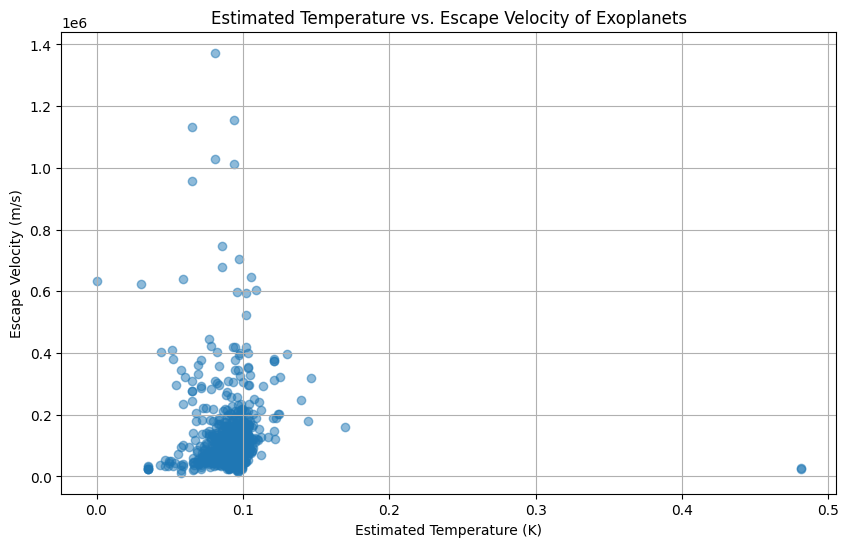

In [10]:
'''6. Calculate the escape velocities of exoplanets and compare them to their estimated temperatures. Present a plot of estimated temperature with escape velocity. Explain the nature of the plot obtained. [20]'''
import numpy as np
# Constants
G = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2


# Calculate escape velocity
df['Escape Velocity'] = np.sqrt((2 * G * df['P_MASS'] * 1e24) / (df['P_RADIUS'] * 1000))  # Convert mass to kg and radius to meters

# Plot estimated temperature with escape velocity
plt.figure(figsize=(10, 6))
plt.scatter(df['S_TEMPERATURE'], df['Escape Velocity'], alpha=0.5)
plt.title('Estimated Temperature vs. Escape Velocity of Exoplanets')
plt.xlabel('Estimated Temperature (K)')
plt.ylabel('Escape Velocity (m/s)')
plt.grid(True)
plt.show()

In [11]:
# 5. How would you tackle the classification bias (class imbalance) of the Dataset? 
# We can tackle the classification bias (class imbalance) of the dataset by oversampling 
# Using SMOTETomek function 

In [12]:
df = pd.read_excel('/kaggle/input/planet-hunt-dataset/Study_of_exoplanets.xlsx')

In [13]:
# calculating no of habitable planets for futher analysis
# P_HABITABLE : Planet is potentially habitable index (1 = conservative, 2 = optimistic)
count_0 = (df['P_HABITABLE'] == 0).sum()
print("Non habitable : ", count_0)
count_1 = (df['P_HABITABLE'] == 1).sum()
print("Conservative : ", count_1)
count_2 = (df['P_HABITABLE'] == 2).sum()
print("Optimistic : ", count_2)

Non habitable :  3993
Conservative :  21
Optimistic :  34


In [14]:
# Calculating the null values
arr = df.isnull().sum()
# printing entire df so that each row can be seen
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(arr.to_string())

P_NAME                             0
P_STATUS                           0
P_MASS                          2450
P_MASS_ERROR_MIN                2581
P_MASS_ERROR_MAX                2581
P_RADIUS                         909
P_RADIUS_ERROR_MIN               943
P_RADIUS_ERROR_MAX               943
P_YEAR                             0
P_UPDATED                          0
P_PERIOD                         110
P_PERIOD_ERROR_MIN               241
P_PERIOD_ERROR_MAX               241
P_SEMI_MAJOR_AXIS               1681
P_SEMI_MAJOR_AXIS_ERROR_MIN     2485
P_SEMI_MAJOR_AXIS_ERROR_MAX     2484
P_ECCENTRICITY                  2668
P_ECCENTRICITY_ERROR_MIN        3077
P_ECCENTRICITY_ERROR_MAX        3077
P_INCLINATION                   3204
P_INCLINATION_ERROR_MIN         3236
P_INCLINATION_ERROR_MAX         3238
P_OMEGA                         3302
P_OMEGA_ERROR_MIN               3355
P_OMEGA_ERROR_MAX               3355
P_TPERI                         3567
P_TPERI_ERROR_MIN               3576
P

In [15]:
df.shape

(4048, 112)

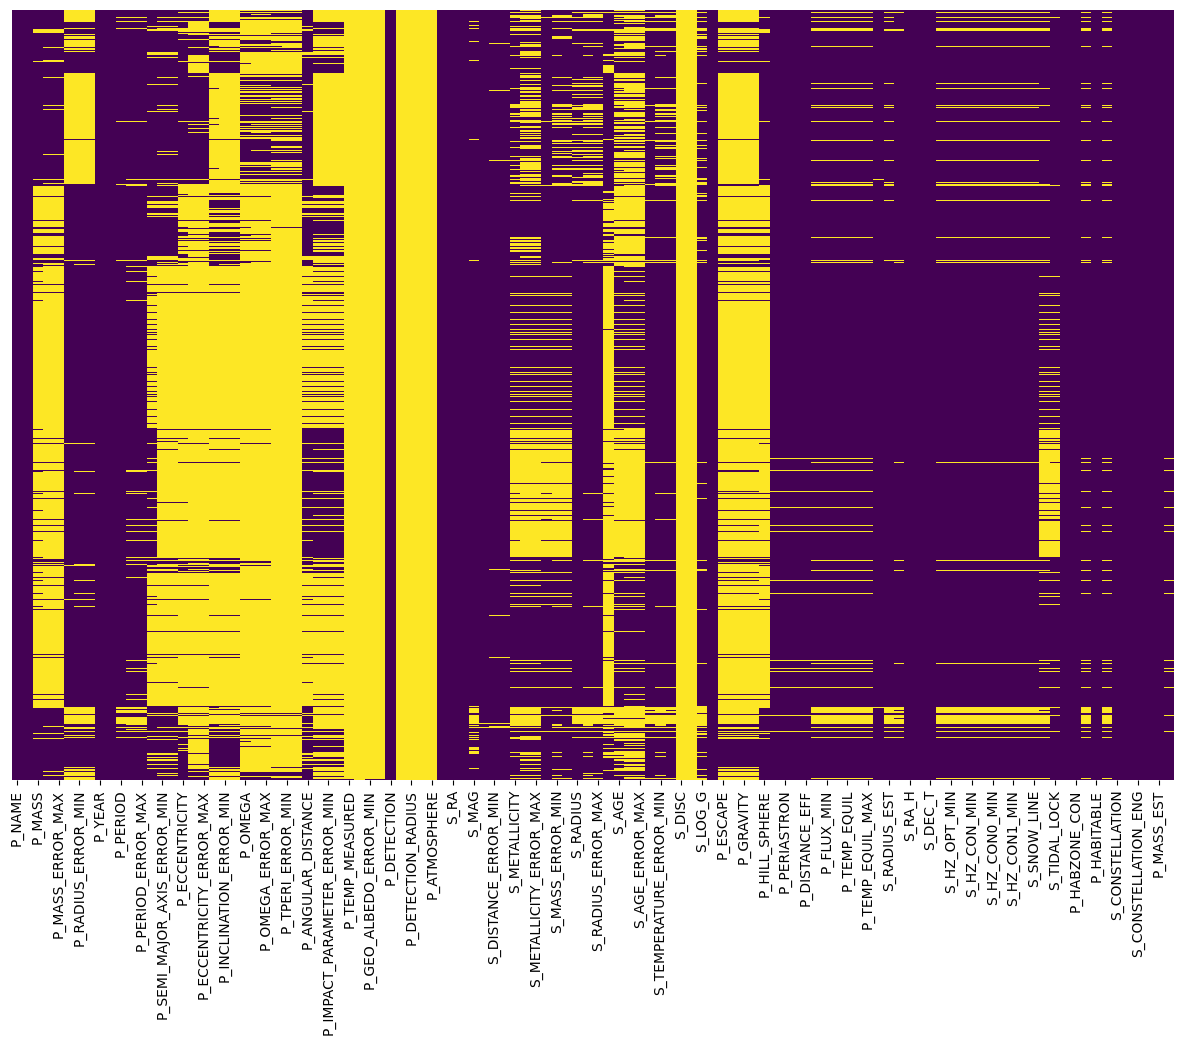

In [16]:
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore

# printing the heatmap of null values wherever you see yellow they are null values
plt.figure(figsize=(15, 10))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

In [17]:
# Dropping all the cols which have almost negligible non null values
dropcols = ['P_GEO_ALBEDO_ERROR_MAX', 'P_GEO_ALBEDO_ERROR_MIN', 'P_GEO_ALBEDO', 'P_TEMP_MEASURED', 'S_MAGNETIC_FIELD', 'S_DISC', 'P_DETECTION_RADIUS', 'P_DETECTION_MASS', 'P_ALT_NAMES', 'P_ATMOSPHERE']
df.drop(columns = dropcols, inplace = True)

In [18]:
df.shape

(4048, 102)

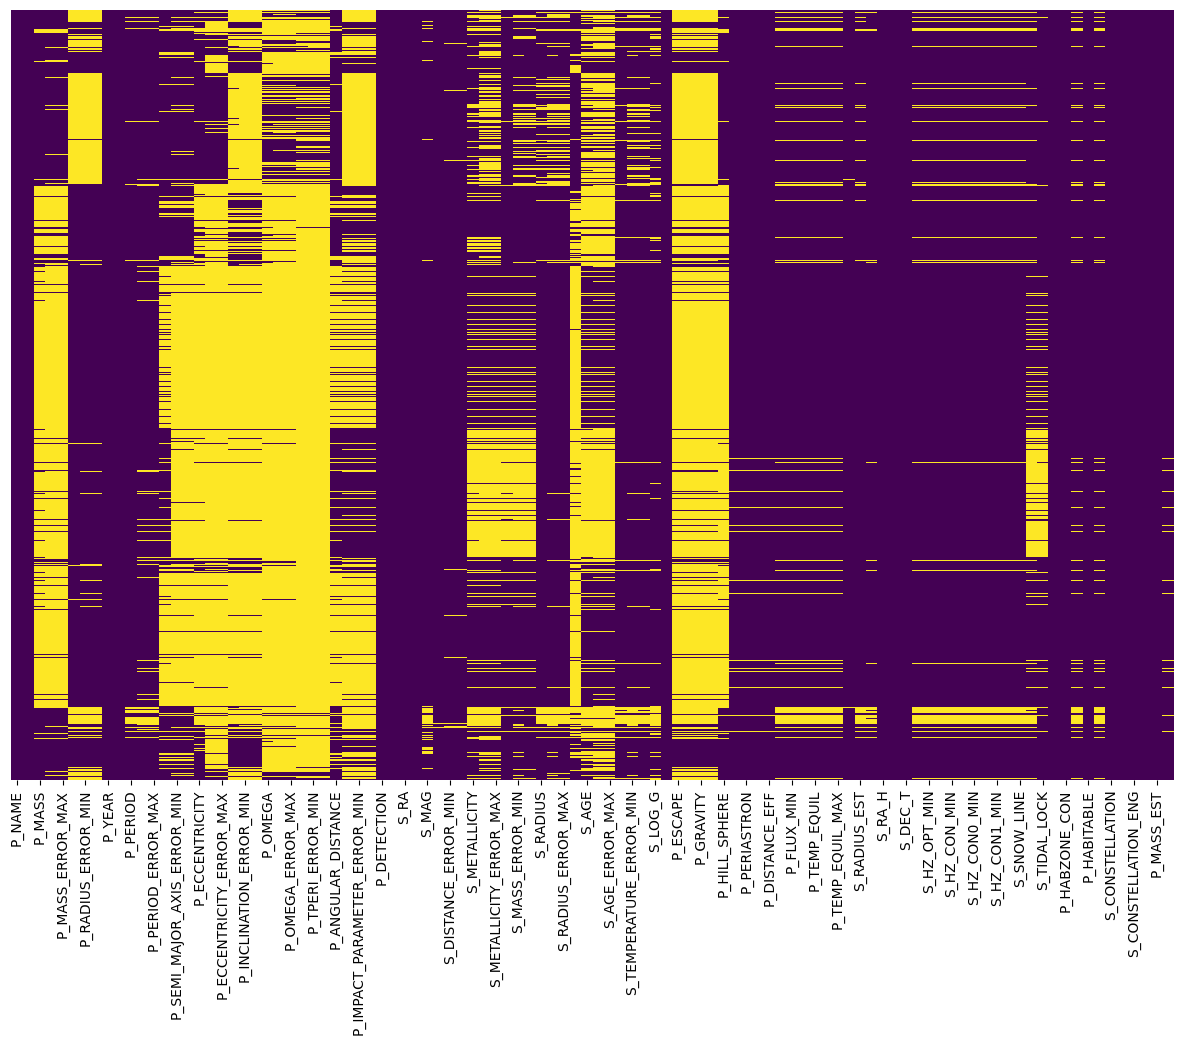

In [19]:
# printing the heat map of null values
plt.figure(figsize=(15, 10))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

In [20]:
# Calculating the info of dataset for evaluation of objects in dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4048 entries, 0 to 4047
Columns: 102 entries, P_NAME to P_SEMI_MAJOR_AXIS_EST
dtypes: float64(83), int64(5), object(14)
memory usage: 3.2+ MB


In [21]:
# Printing all cols which have objects
object_cols = df.select_dtypes(include=['object']).columns
print(object_cols)
# Handeling all objects one by one

Index(['P_NAME', 'P_UPDATED', 'P_DETECTION', 'S_NAME', 'S_TYPE', 'S_ALT_NAMES',
       'P_TYPE', 'S_TYPE_TEMP', 'S_RA_T', 'S_DEC_T', 'P_TYPE_TEMP',
       'S_CONSTELLATION', 'S_CONSTELLATION_ABR', 'S_CONSTELLATION_ENG'],
      dtype='object')


In [22]:
# P_NAME is unique name of each col
# P_UPDATED is datetime col
# P_DETECTION changed to P_DETECTION_encoded
# S_NAME is unique name of each planet and has many null values so (drop)
# S_TYPE is unique name of each planet and has many null values so (drop)
# S_ALT_NAMES has many classes 584 so (drop)
# P_TYPE changed to P_TYPE_encoded
# S_TYPE_TEMP changed to S_TYPE_TEMP_encoded
# S_RA_T too many unique values so (drop)
# S_DEC_T too many unique values so (drop)
# P_TYPE_TEMP changed to P_TYPE_TEMP_encoded
# S_CONSTELLATION changed to S_CONSTELLATION_encoded
# S_CONSTELLATION_ABR changed to S_CONSTELLATION_ABR_encoded
# S_CONSTELLATION_ENG changed to S_CONSTELLATION_ENG_encoded

In [23]:
# Printing all unique value of P_DETECTION
unique_values = df['P_DETECTION'].unique()
print(unique_values.shape)
print(unique_values)
# Since it is a categorical col using LabelEncoder for encoding the col
from sklearn.preprocessing import LabelEncoder # type: ignore
label_encoder = LabelEncoder()
# Storing the encoded col in new _encoded col
df['P_DETECTION_encoded'] = label_encoder.fit_transform(df['P_DETECTION'])
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

(10,)
['Radial Velocity' 'Imaging' 'Eclipse Timing Variations' 'Transit'
 'Astrometry' 'Orbital Brightness Modulation'
 'Pulsation Timing Variations' 'Microlensing' 'Transit Timing Variations'
 'Pulsar Timing']
{'Astrometry': 0, 'Eclipse Timing Variations': 1, 'Imaging': 2, 'Microlensing': 3, 'Orbital Brightness Modulation': 4, 'Pulsar Timing': 5, 'Pulsation Timing Variations': 6, 'Radial Velocity': 7, 'Transit': 8, 'Transit Timing Variations': 9}


In [24]:
# Printing all unique value of P_TYPE
unique_values = df['P_TYPE'].unique()
print(unique_values.shape)
print(unique_values)
# Storing the encoded col in new _encoded col
df['P_TYPE_encoded'] = label_encoder.fit_transform(df['P_TYPE'])
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

(7,)
['Jovian' nan 'Superterran' 'Neptunian' 'Subterran' 'Terran' 'Miniterran']
{'Jovian': 0, 'Miniterran': 1, 'Neptunian': 2, 'Subterran': 3, 'Superterran': 4, 'Terran': 5, nan: 6}


In [25]:
# Printing all unique value of S_TYPE_TEMP
unique_values = df['S_TYPE_TEMP'].unique()
print(unique_values.shape)
print(unique_values)
# Storing the encoded col in new _encoded col
df['S_TYPE_TEMP_encoded'] = label_encoder.fit_transform(df['S_TYPE_TEMP'])
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

(8,)
['K' 'G' 'M' nan 'F' 'B' 'A' 'O']
{'A': 0, 'B': 1, 'F': 2, 'G': 3, 'K': 4, 'M': 5, 'O': 6, nan: 7}


In [26]:
# Printing all unique value of P_TYPE_TEMP
unique_values = df['P_TYPE_TEMP'].unique()
print(unique_values.shape)
print(unique_values)
# Storing the encoded col in new _encoded col
df['P_TYPE_TEMP_encoded'] = label_encoder.fit_transform(df['P_TYPE_TEMP'])
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

(4,)
['Hot' 'Cold' 'Warm' nan]
{'Cold': 0, 'Hot': 1, 'Warm': 2, nan: 3}


In [27]:
# Printing all unique value of S_CONSTELLATION
unique_values = df['S_CONSTELLATION'].unique()
print(unique_values.shape)
print(unique_values)
# Storing the encoded col in new _encoded col
df['S_CONSTELLATION_encoded'] = label_encoder.fit_transform(df['S_CONSTELLATION'])
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

(88,)
['Coma Berenices' 'Ursa Minor' 'Andromeda' 'Hercules' 'Cygnus' 'Delphinus'
 'Scorpius' 'Bootes' 'Sextans' 'Cetus' 'Fornax' 'Taurus' 'Centaurus'
 'Pegasus' 'Lacerta' 'Aries' 'Ursa Major' 'Draco' 'Eridanus' 'Cancer'
 'Lynx' 'Virgo' 'Canis Major' 'Aquarius' 'Pictor' 'Leo' 'Serpens' 'Pisces'
 'Perseus' 'Orion' 'Crater' 'Scutum' 'Puppis' 'Chamaeleon' 'Monoceros'
 'Aquila' 'Ophiuchus' 'Canes Venatici' 'Vela' 'Tucana' 'Piscis Austrinus'
 'Reticulum' 'Dorado' 'Canis Minor' 'Hydrus' 'Pyxis' 'Hydra' 'Columba'
 'Cepheus' 'Libra' 'Ara' 'Grus' 'Lupus' 'Cassiopeia' 'Gemini' 'Sagitta'
 'Triangulum' 'Vulpecula' 'Lyra' 'Equuleus' 'Auriga' 'Sagittarius'
 'Capricornus' 'Sculptor' 'Telescopium' 'Pavo' 'Antlia' 'Phoenix' 'Lepus'
 'Musca' 'Corvus' 'Camelopardalis' 'Crux' 'Circinus' 'Apus' 'Octans'
 'Norma' 'Corona Borealis' 'Triangulum Australe' 'Corona Australis'
 'Indus' 'Horologium' 'Caelum' 'Mensa' 'Carina' 'Volans' 'Leo Minor'
 'Microscopium']
{'Andromeda': 0, 'Antlia': 1, 'Apus': 2, 'Aquarius': 

In [28]:
# Printing all unique value of S_CONSTELLATION_ABR
unique_values = df['S_CONSTELLATION_ABR'].unique()
print(unique_values.shape)
print(unique_values)
# Storing the encoded col in new _encoded col
df['S_CONSTELLATION_ABR_encoded'] = label_encoder.fit_transform(df['S_CONSTELLATION_ABR'])
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

(88,)
['Com' 'UMi' 'And' 'Her' 'Cyg' 'Del' 'Sco' 'Boo' 'Sex' 'Cet' 'For' 'Tau'
 'Cen' 'Peg' 'Lac' 'Ari' 'UMa' 'Dra' 'Eri' 'Cnc' 'Lyn' 'Vir' 'CMa' 'Aqr'
 'Pic' 'Leo' 'Ser' 'Psc' 'Per' 'Ori' 'Crt' 'Sct' 'Pup' 'Cha' 'Mon' 'Aql'
 'Oph' 'CVn' 'Vel' 'Tuc' 'PsA' 'Ret' 'Dor' 'CMi' 'Hyi' 'Pyx' 'Hya' 'Col'
 'Cep' 'Lib' 'Ara' 'Gru' 'Lup' 'Cas' 'Gem' 'Sge' 'Tri' 'Vul' 'Lyr' 'Equ'
 'Aur' 'Sgr' 'Cap' 'Scl' 'Tel' 'Pav' 'Ant' 'Phe' 'Lep' 'Mus' 'Crv' 'Cam'
 'Cru' 'Cir' 'Aps' 'Oct' 'Nor' 'CrB' 'TrA' 'CrA' 'Ind' 'Hor' 'Cae' 'Men'
 'Car' 'Vol' 'LMi' 'Mic']
{'And': 0, 'Ant': 1, 'Aps': 2, 'Aql': 3, 'Aqr': 4, 'Ara': 5, 'Ari': 6, 'Aur': 7, 'Boo': 8, 'CMa': 9, 'CMi': 10, 'CVn': 11, 'Cae': 12, 'Cam': 13, 'Cap': 14, 'Car': 15, 'Cas': 16, 'Cen': 17, 'Cep': 18, 'Cet': 19, 'Cha': 20, 'Cir': 21, 'Cnc': 22, 'Col': 23, 'Com': 24, 'CrA': 25, 'CrB': 26, 'Crt': 27, 'Cru': 28, 'Crv': 29, 'Cyg': 30, 'Del': 31, 'Dor': 32, 'Dra': 33, 'Equ': 34, 'Eri': 35, 'For': 36, 'Gem': 37, 'Gru': 38, 'Her': 39, 'Hor': 40, 'Hya': 41, 'Hyi

In [29]:
# Printing all unique value of S_CONSTELLATION_ENG
unique_values = df['S_CONSTELLATION_ENG'].unique()
print(unique_values.shape)
print(unique_values)
# Storing the encoded col in new _encoded col
df['S_CONSTELLATION_ENG_encoded'] = label_encoder.fit_transform(df['S_CONSTELLATION_ENG'])
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

(88,)
["Berenice's Hair" 'Little Bear' 'Andromeda' 'Hercules' 'Swan' 'Dolphin'
 'Scorpion' 'Herdsman' 'Sextant' 'Whale' 'Furnace' 'Bull' 'Centaur'
 'Winged Horse' 'Lizard' 'Ram' 'Big Bear' 'Dragon' 'River' 'Crab' 'Lynx'
 'Virgin' 'Big Dog' 'Water Carrier' "Painter's Easel" 'Lion' 'Serpent'
 'Fishes' 'Perseus' 'Hunter' 'Cup' 'Shield' 'Stern' 'Chameleon' 'Unicorn'
 'Eagle' 'Serpent Holder' 'Hunting Dogs' 'Sails' 'Toucan' 'Southern Fish'
 'Net' 'Goldfish' 'Little Dog' 'Little Water Snake' 'Compass'
 'Water Snake' 'Dove' 'Cepheus' 'Scales' 'Altar' 'Crane' 'Wolf'
 'Cassiopeia' 'Twins' 'Arrow' 'Triangle' 'Fox' 'Lyre' 'Little Horse'
 'Charioteer' 'Archer' 'Sea Goat' 'Sculptor' 'Telescope' 'Peacock'
 'Air Pump' 'Phoenix' 'Hare' 'Fly' 'Crow' 'Giraffe' 'Southern Cross'
 'Compasses' 'Bird of Paradise' 'Octant' 'Level' 'Northern Crown'
 'Southern Triangle' 'Southern Crown' 'Indian' 'Pendulum Clock' 'Chisel'
 'Table' 'Keel' 'Flying Fish' 'Little Lion' 'Microscope']
{'Air Pump': 0, 'Altar': 1, 'Andr

In [30]:
# P_NAME is unique name of each col
# P_UPDATED is datetime col
# P_DETECTION changed to P_DETECTION_encoded
# S_NAME is unique name of each planet and has many null values so (drop)
# S_TYPE is unique name of each planet and has many null values so (drop)
# S_ALT_NAMES has many classes 584 so (drop)
# P_TYPE changed to P_TYPE_encoded
# S_TYPE_TEMP changed to S_TYPE_TEMP_encoded
# S_RA_T too many unique values so (drop)
# S_DEC_T too many unique values so (drop)
# P_TYPE_TEMP changed to P_TYPE_TEMP_encoded
# S_CONSTELLATION changed to S_CONSTELLATION_encoded
# S_CONSTELLATION_ABR changed to S_CONSTELLATION_ABR_encoded
# S_CONSTELLATION_ENG changed to S_CONSTELLATION_ENG_encoded

In [31]:
dropcols = ['P_UPDATED', 'P_DETECTION', 'S_NAME', 'S_TYPE', 'S_ALT_NAMES', 'P_TYPE', 'S_TYPE_TEMP', 'S_RA_T', 'S_DEC_T', 'P_TYPE_TEMP', 'S_CONSTELLATION', 'S_CONSTELLATION_ABR', 'S_CONSTELLATION_ENG']
df.drop(columns = dropcols, inplace = True)

In [32]:
df.shape

(4048, 96)

In [33]:
df.head()

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_PERIOD,P_PERIOD_ERROR_MIN,P_PERIOD_ERROR_MAX,P_SEMI_MAJOR_AXIS,P_SEMI_MAJOR_AXIS_ERROR_MIN,P_SEMI_MAJOR_AXIS_ERROR_MAX,P_ECCENTRICITY,P_ECCENTRICITY_ERROR_MIN,P_ECCENTRICITY_ERROR_MAX,P_INCLINATION,P_INCLINATION_ERROR_MIN,P_INCLINATION_ERROR_MAX,P_OMEGA,P_OMEGA_ERROR_MIN,P_OMEGA_ERROR_MAX,P_TPERI,P_TPERI_ERROR_MIN,P_TPERI_ERROR_MAX,P_ANGULAR_DISTANCE,P_IMPACT_PARAMETER,P_IMPACT_PARAMETER_ERROR_MIN,P_IMPACT_PARAMETER_ERROR_MAX,S_RA,S_DEC,S_MAG,S_DISTANCE,S_DISTANCE_ERROR_MIN,S_DISTANCE_ERROR_MAX,S_METALLICITY,S_METALLICITY_ERROR_MIN,S_METALLICITY_ERROR_MAX,S_MASS,S_MASS_ERROR_MIN,S_MASS_ERROR_MAX,S_RADIUS,S_RADIUS_ERROR_MIN,S_RADIUS_ERROR_MAX,S_AGE,S_AGE_ERROR_MIN,S_AGE_ERROR_MAX,S_TEMPERATURE,S_TEMPERATURE_ERROR_MIN,S_TEMPERATURE_ERROR_MAX,S_LOG_G,P_ESCAPE,P_POTENTIAL,P_GRAVITY,P_DENSITY,P_HILL_SPHERE,P_DISTANCE,P_PERIASTRON,P_APASTRON,P_DISTANCE_EFF,P_FLUX,P_FLUX_MIN,P_FLUX_MAX,P_TEMP_EQUIL,P_TEMP_EQUIL_MIN,P_TEMP_EQUIL_MAX,S_RADIUS_EST,S_RA_H,S_LUMINOSITY,S_HZ_OPT_MIN,S_HZ_OPT_MAX,S_HZ_CON_MIN,S_HZ_CON_MAX,S_HZ_CON0_MIN,S_HZ_CON0_MAX,S_HZ_CON1_MIN,S_HZ_CON1_MAX,S_SNOW_LINE,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_HABITABLE,P_ESI,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST,P_DETECTION_encoded,P_TYPE_encoded,S_TYPE_TEMP_encoded,P_TYPE_TEMP_encoded,S_CONSTELLATION_encoded,S_CONSTELLATION_ABR_encoded,S_CONSTELLATION_ENG_encoded
0,11 Com b,3,6165.86330,-476.74200,476.74200,NaN,NaN,NaN,2007,326.03000,-0.32,0.32,1.29,-0.05,0.05,0.231,-0.005,0.005,NaN,NaN,NaN,94.8,-1.5,1.5,2452899.6,-1.6,1.6,13.8,NaN,NaN,NaN,185.17928,17.792868,4.740,93.37,-1.92,1.92,-0.35,-0.09,0.09,2.70,-0.30,0.30,19.00,-2.00,2.00,NaN,NaN,NaN,4742.0,-100.0,100.0,2.31,NaN,NaN,NaN,NaN,0.130671,1.324418,0.99201,1.58799,1.298759,101.011410,64.855456,166.191940,799.44963,722.98875,914.73942,19.00,12.345286,163.546800,10.132812,24.763411,12.834754,23.477907,13.586847,23.477907,12.390643,23.477907,34.529063,0.476460,0.642400,0,0,0,0.083813,12.082709,6165.86330,1.29,7,0,4,1,24,24,5
1,11 UMi b,3,4684.78480,-794.57001,794.57001,NaN,NaN,NaN,2009,516.21997,-3.20,3.20,1.53,-0.07,0.07,0.080,-0.030,0.030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.2,NaN,NaN,NaN,229.27454,71.823898,5.016,125.72,-1.97,1.97,-0.02,NaN,NaN,2.78,-0.69,0.69,29.79,-2.84,2.84,NaN,NaN,NaN,4213.0,-46.0,46.0,1.93,NaN,NaN,NaN,NaN,0.167551,1.534896,1.40760,1.65240,1.531227,107.351180,91.741348,126.426170,819.07569,788.47184,854.28770,29.79,15.284970,250.492940,12.770059,31.984271,16.175280,30.323783,17.134143,30.323783,15.615215,30.323783,42.732816,0.193891,0.648683,0,0,0,0.082414,12.229641,4684.78480,1.53,7,0,4,1,83,83,42
2,14 And b,3,1525.57440,NaN,NaN,NaN,NaN,NaN,2008,185.84000,-0.23,0.23,0.83,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2452861.4,-1.5,1.5,11.0,NaN,NaN,NaN,352.82257,39.236198,5.227,75.59,-0.71,0.71,-0.24,-0.03,0.03,2.20,-0.20,0.10,11.00,-1.00,1.00,NaN,NaN,NaN,4813.0,-20.0,20.0,2.63,NaN,NaN,NaN,NaN,0.073485,0.830000,0.83000,0.83000,0.830000,84.446427,84.446427,84.446427,772.30746,772.30746,772.30746,11.00,23.521506,58.175144,6.025230,14.680087,7.631867,13.918028,8.078404,13.918028,7.367780,13.918028,20.593611,0.502752,0.600010,0,0,0,0.081917,12.848516,1525.57440,0.83,7,0,3,1,0,0,2
3,14 Her b,3,1481.07850,-47.67420,47.67420,NaN,NaN,NaN,2002,1773.40000,-2.50,2.50,2.93,-0.08,0.08,0.370,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,163.0,NaN,NaN,NaN,242.60130,43.817646,6.610,17.94,-0.01,0.01,0.41,NaN,NaN,0.90,-0.04,0.04,0.93,-0.01,0.01,NaN,NaN,NaN,5338.0,-25.0,25.0,4.45,NaN,NaN,NaN,NaN,0.217991,3.130558,1.84590,4.01410,2.982550,0.078887,0.039047,0.184651,131.38424,113.25125,167.00637,0.93,16.173421,0.629171,0.610595,1.457913,0.773404,1.382234,0.818179,1.382234,0.746615,1.382234,2.141648,0.919756,0.445415,0,0,0,0.145241,12.865261,1481.07850,2.93,7,0,4,0,39,39,34
4,16 Cyg B b,3,565.73385,-25.42624,25.42624,NaN,NaN,NaN,1996,798.50000,-1.00,1.00,1.66,-0.03,0.03,0.680,-0.02

In [34]:
for index, row in df.iterrows():
    for col in df.columns:
        if pd.isnull(row[col]):
            cls = row['P_HABITABLE']
            median_val = df[df['P_HABITABLE'] == cls][col].median()
            df.at[index, col] = median_val

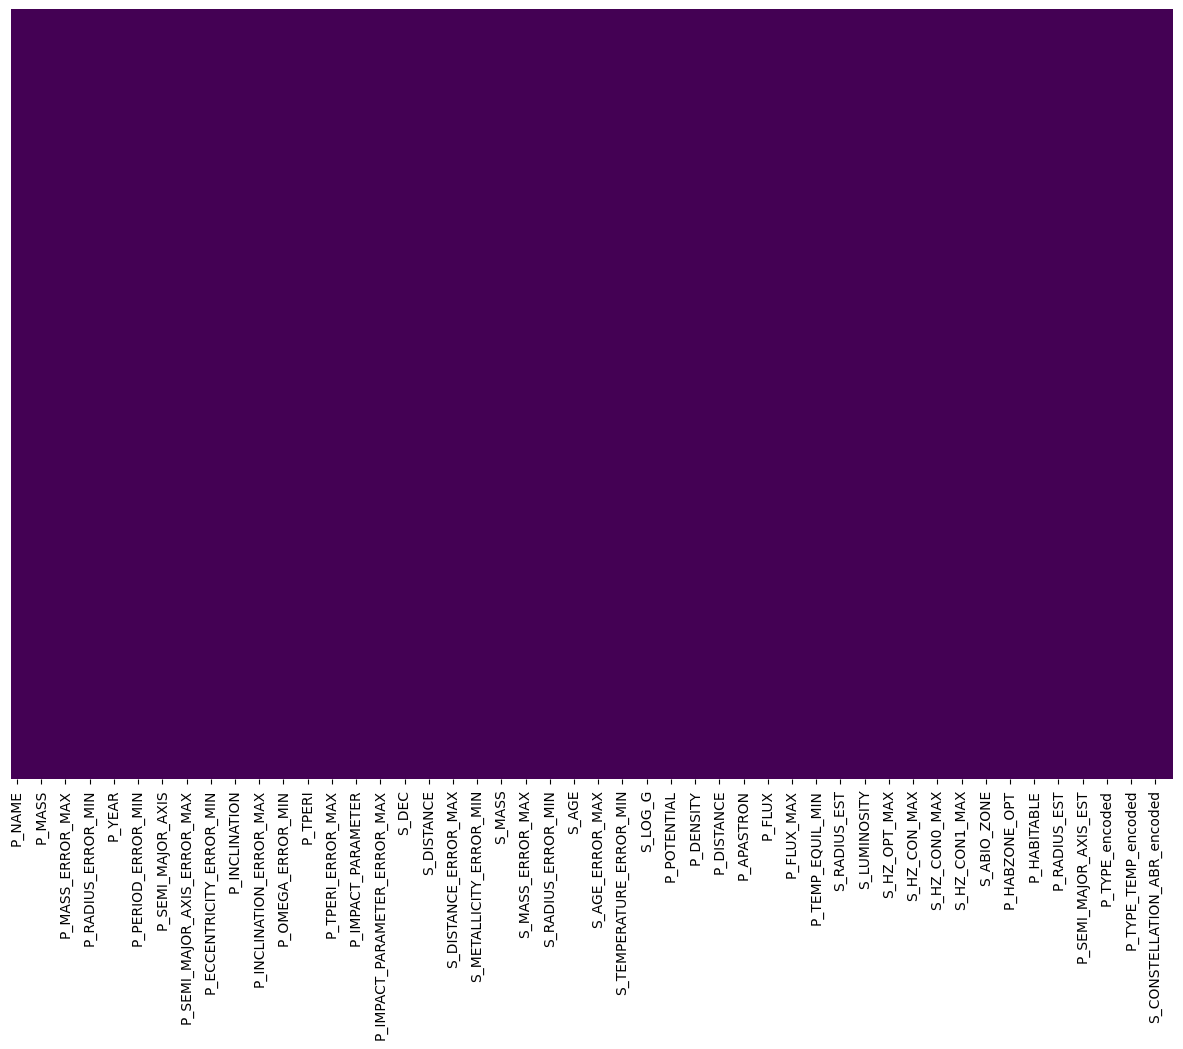

In [35]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

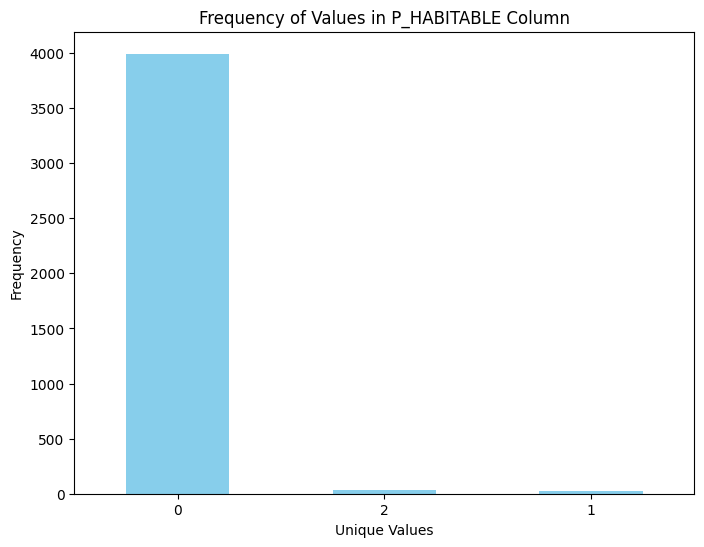

In [36]:
import matplotlib.pyplot as plt # type: ignore

value_counts = df['P_HABITABLE'].value_counts()

plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Values in P_HABITABLE Column')
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()


In [37]:
# Excluding the target col from dataset
df_no_target = df.drop(['P_HABITABLE'], axis = 1)
df_no_target.shape

(4048, 95)

In [38]:
# Indexing the dataframe
new_index = range(1, 4049)
df_no_target['id'] = new_index

In [39]:
df_no_target.shape

(4048, 96)

In [40]:
X = df_no_target.drop(columns = 'P_NAME')
y = df[['P_HABITABLE']]

In [41]:
print(X.shape)
print(y.shape)

(4048, 95)
(4048, 1)


In [42]:
habitable = df[df['P_HABITABLE']==0]
conservative = df[df['P_HABITABLE']==1]
optimistic = df[df['P_HABITABLE']==2]

In [43]:
print(habitable.shape, conservative.shape, optimistic.shape)

(3993, 96) (21, 96) (34, 96)


In [44]:
from imblearn.combine import SMOTETomek # type: ignore
smk = SMOTETomek(random_state=42)
X_res, y_res = smk.fit_resample(X, y)
print(X_res.shape, y_res.shape)

(11955, 95) (11955, 1)


In [45]:
habitable = y_res[y_res['P_HABITABLE']==0]
conservative = y_res[y_res['P_HABITABLE']==1]
optimistic = y_res[y_res['P_HABITABLE']==2]
print(habitable.shape, conservative.shape, optimistic.shape)

(3992, 1) (3982, 1) (3981, 1)


In [46]:
from sklearn.decomposition import PCA # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.neighbors import KNeighborsClassifier # type: ignore
from sklearn.metrics import accuracy_score # type: ignore

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_res, test_size=0.2, random_state=42)

pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_pca, y_train)

y_pred = knn.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

/opt/conda/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.999163529903806


In [47]:
# Printing the Classification Report
from sklearn.metrics import classification_report # type: ignore

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       802
           1       1.00      1.00      1.00       792
           2       1.00      1.00      1.00       797

    accuracy                           1.00      2391
   macro avg       1.00      1.00      1.00      2391
weighted avg       1.00      1.00      1.00      2391



In [48]:
from sklearn.svm import SVC # type: ignore

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_res, test_size=0.2, random_state=42)

pca = PCA(n_components=20)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

svm = SVC(C=1, gamma='scale', kernel='rbf')
svm.fit(X_train_pca, y_train)

y_pred = svm.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.999581764951903


In [49]:
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       802
           1       1.00      1.00      1.00       792
           2       1.00      1.00      1.00       797

    accuracy                           1.00      2391
   macro avg       1.00      1.00      1.00      2391
weighted avg       1.00      1.00      1.00      2391



In [50]:
from sklearn.model_selection import train_test_split, GridSearchCV # type: ignore

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_res, test_size=0.2, random_state=42)

best_accuracy = 0
best_n_components = 0

for i in range(1, 7):
    pca = PCA(n_components=10*i)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    svm = SVC()
    param_grid = {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto']
    }

    grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train_pca, y_train)

    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)

    best_svm = grid_search.best_estimator_

    y_pred = best_svm.predict(X_test_pca)

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_components = 10*i

print("Best Accuracy:", best_accuracy)
print("Best n_components:", best_n_components)


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best Parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.999163529903806


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.999581764951903


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best Parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.999581764951903


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best Parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.999581764951903


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.999581764951903


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.999581764951903
Best Accuracy: 0.999581764951903
Best n_components: 20
